#Facial Boundary and Facial Landmarks Detection
In this project, we built 2 models that while working together, can get any image, find multiple bounding boxes in them that each potentially contain a face, and then find 68 landmarks in each of them. \\
In this notebook we do not train the models nor go through our dataset; however, This notebook is only dedicated to the usage of the project. \\
You can view the code and the process of training each of these models in the following notebooks:
1. [Part 1 - Facial Boundary Detection - RCNN](https://colab.research.google.com/drive/1Xrq_DMWYPgOz0P8U6JP5EcnVbvTtPc9k?usp=sharing)
2. [Part 2 - Facial Landmarks Detection](https://colab.research.google.com/drive/1bjt13XIs5PddRa9JiB5nkbtCrr-RAqWt?usp=sharing)

Also, you can download our [pre-trained models](https://drive.google.com/drive/folders/1c_ze_4aHxxI0RQVpwE_jqS4lbRs-5FD2?usp=sharing) as well as our [dataset](https://drive.google.com/file/d/1NFK3swEXOHFEsdIUT50PabBniTbJ-vNu/view?usp=sharing).

In [ ]:
# Required Packages

import os
import cv2
import random
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from numpy import expand_dims
import matplotlib.pyplot as plt

**Please consider that this code is based on my google drive and the access that I have granted this code to it. To use this code on your own, you need to download the weights and move them to your own drive.**

In [ ]:
# loading models

os.chdir("/content/drive/MyDrive/Weights")

rcnn_model = tf.keras.models.load_model("ieeercnn_vgg16.h5")
landmark_model = tf.keras.models.load_model("lm_det.h5")

## RCNN Model
In the following cell, you will see a representation of the model responsible for detecting bounding boxes. To gain furthur information, take a look at [our reference](https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55).

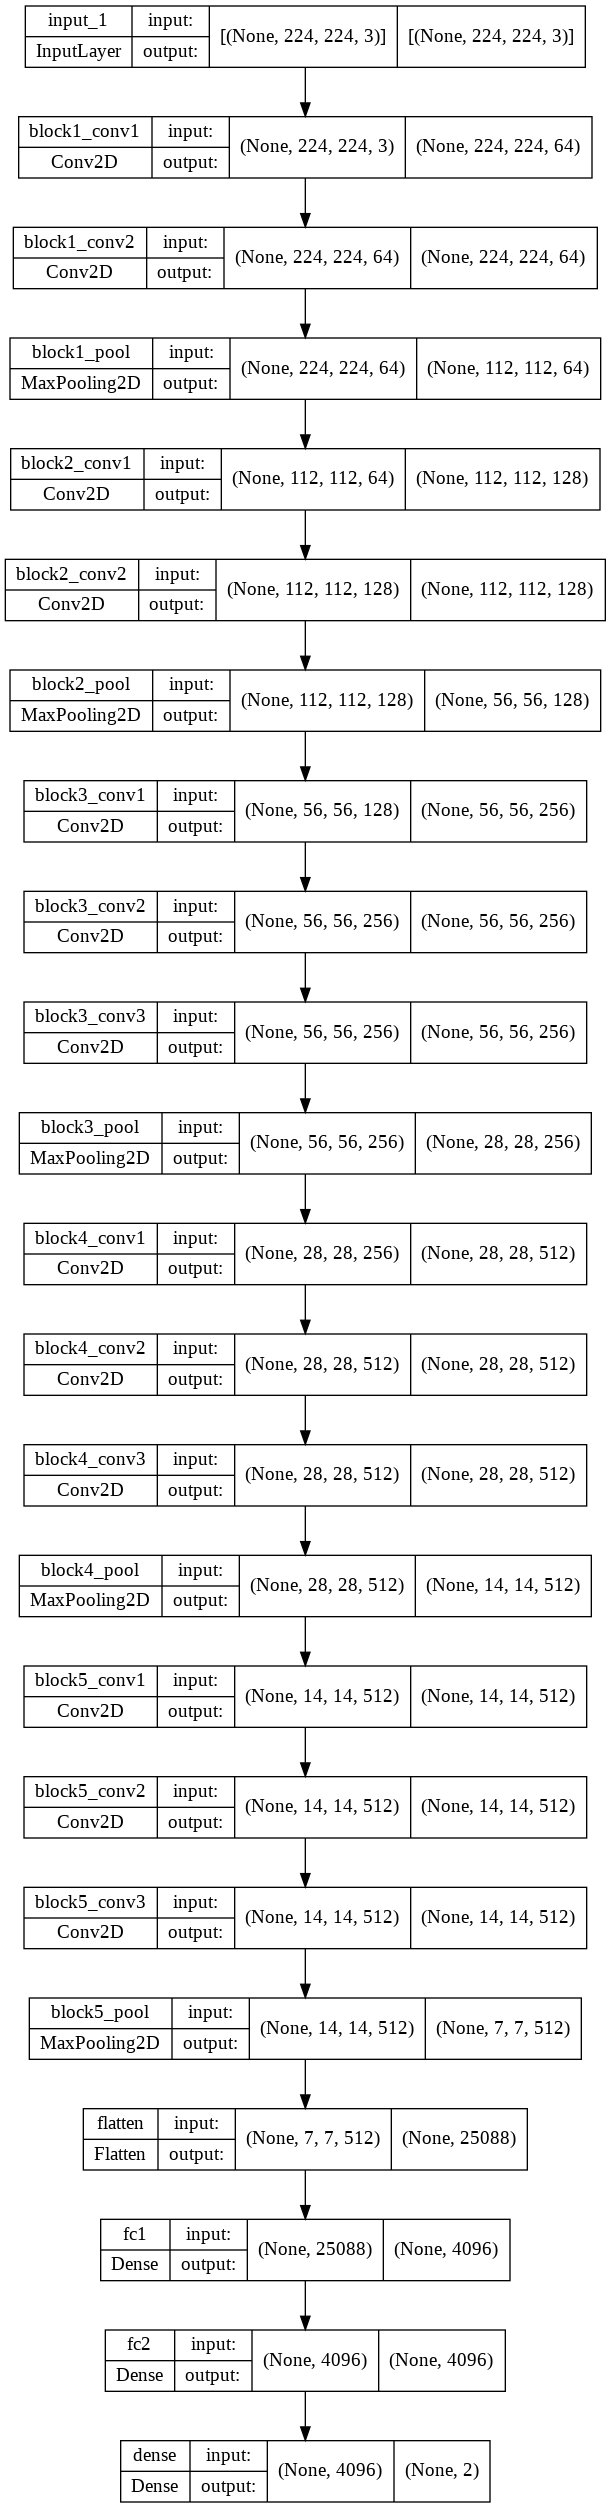

In [ ]:
tf.keras.utils.plot_model(rcnn_model, show_shapes=True)

## Facial Landmarks Detection
In addition, you get to take a glimpse of the structure of the second model as well.

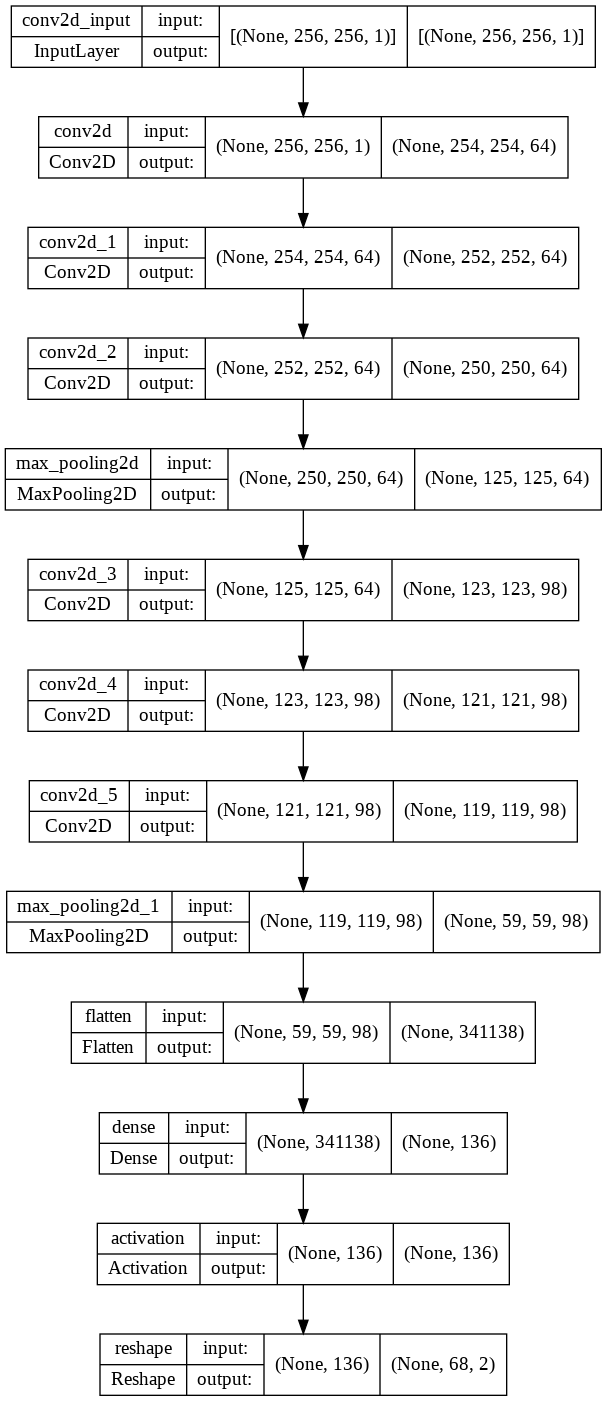

In [ ]:

tf.keras.utils.plot_model(landmark_model, show_shapes=True)

## How to use?
When you run the cell beneath, you will be able to upload any file you want. Do that so you can feed your image to the models.

In [ ]:
from google.colab import files

os.chdir("/content/")
uploaded = files.upload()

Saving himym.jpg to himym.jpg


Then, remember to also enter the name of your file, so that the code would be able to access it.

In [ ]:
# Enter your filename here
filename = "kobe.jpg"

path = "/content/" + filename

In [ ]:
def select_boxes(founded):
    selected = []

    if len(founded) == 1:
        selected.append(founded[0])
    for i in range(len(founded)):
        is_best = True
        x1, y1, w1, h1 = founded[i][1]
        if (0.8) < (w1 / h1) <= (1):
            for j in range(len(founded)):
                if i != j:
                    ch1, ch2 = founded[i][0], founded[j][0]
                    x2, y2, w2, h2 = founded[j][1]
                    if (0.8) < (w2 / h2) <= (1):
                        if abs(x1 - x2) < max(w1, w2) // 2 or abs(y1 - y2) < max(h1, h2) // 2:
                            if ch1 < ch2:
                                is_best = False
                                break
            if is_best:
                selected.append(founded[i][1])
    return selected

In [ ]:
# Do not change these variables
new_heigth_rcnn, new_width_rcnn = 200, 200
new_width_lm, new_heigth_lm = 256, 256
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

100%|██████████| 403/403 [00:24<00:00, 16.41it/s]


[(0.99571323, [27, 4, 144, 175]), (0.98846227, [13, 4, 157, 178]), (0.96120805, [8, 1, 174, 181]), (0.9736795, [25, 5, 147, 146]), (0.9815283, [34, 59, 131, 123]), (0.96534747, [0, 0, 170, 182]), (0.9773069, [13, 4, 169, 178]), (0.9635454, [29, 38, 171, 162]), (0.9922242, [15, 13, 151, 169]), (0.9670816, [8, 4, 174, 178]), (0.99454284, [27, 1, 144, 178]), (0.99254686, [34, 52, 131, 130]), (0.97398496, [34, 52, 132, 148]), (0.977979, [41, 52, 117, 111]), (0.9756115, [32, 61, 131, 115]), (0.9669465, [15, 1, 169, 199]), (0.9883885, [25, 5, 159, 195]), (0.97688043, [25, 1, 147, 150]), (0.9912019, [27, 1, 156, 178]), (0.98003525, [15, 1, 168, 178]), (0.96973294, [34, 30, 166, 170]), (0.9839579, [25, 1, 159, 199]), (0.9754032, [15, 1, 167, 181])]


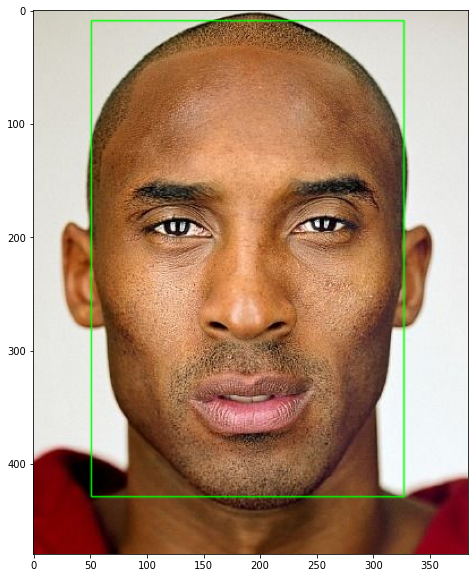

In [ ]:
image = cv2.imread(path)
cur_heigth, cur_width = image.shape[:2]
image = cv2.resize(image, (new_width_rcnn, new_heigth_rcnn), fx=(new_width_rcnn/cur_width), fy=(new_heigth_rcnn/cur_heigth), interpolation=cv2.INTER_CUBIC)
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = image.copy()
founded = []
pbar = tqdm(total=len(ssresults))
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= rcnn_model.predict(img)
        if out[0][0] > 0.95:
            founded.append((out[0][0], [x, y, w, h]))
    pbar.update(1)
pbar.close()
print(founded)
boxes = select_boxes(founded)
temp = cv2.imread(path)
for box in boxes:
    x, y, w, h = box
    x, w = int(x * (temp.shape[1] / new_width_rcnn)), int(w * (temp.shape[1] / new_width_rcnn))
    y, h = int(y * (temp.shape[0] / new_heigth_rcnn)), int(h * (temp.shape[0] / new_heigth_rcnn))
    cv2.rectangle(temp, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
temp = temp[:, :, ::-1]
plt.rcParams['figure.figsize'] = [10, 10]
plt.figure()
plt.imshow(temp)
plt.show()

In [ ]:
def show_image(image, boxes, predicted):
    plt.rcParams['figure.figsize'] = [10, 10]
    for i in range(faces.shape[0]):
        landmarks = predicted[i, :, :].copy()
        temp = []
        x, y, w, h = boxes[i]
        x, w = int(x * (image.shape[1] / new_width_rcnn)), int(w * (image.shape[1] / new_width_rcnn))
        y, h = int(y * (image.shape[0] / new_heigth_rcnn)), int(h * (image.shape[0] / new_heigth_rcnn))
        for j in range(0, landmarks.shape[0]):
            x_l, y_l = landmarks[j, :].copy()
            x_l, y_l = x_l * w // new_width_lm, y_l * h // new_heigth_lm
            x_l, y_l = x_l + x, y_l + y
            plt.plot(x_l, y_l, '.r')
    plt.imshow(image)
    plt.show()

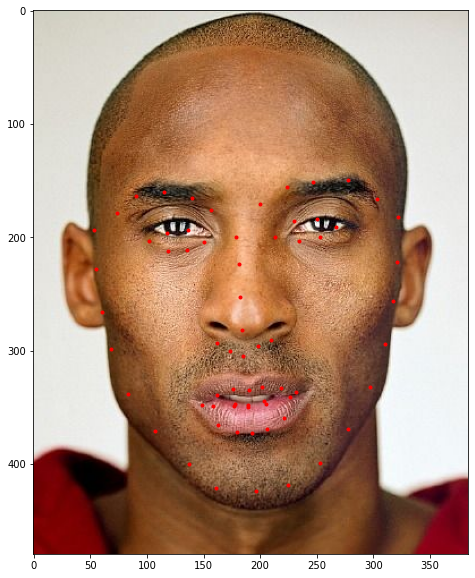

In [ ]:
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
image_colored = cv2.imread(path)
image_colored = image_colored[:, :, ::-1]
image = cv2.resize(image, (new_heigth_rcnn, new_width_rcnn), interpolation=cv2.INTER_CUBIC)
faces = []
for box in boxes:
  x, y, w, h = box
  face_img = image[y:y+h, x:x+w]
  face_img = cv2.resize(face_img, (new_width_lm, new_heigth_lm), 
                        fx=(new_width_lm/w), fy=(new_heigth_lm/h), 
                        interpolation=cv2.INTER_CUBIC)
  faces.append(face_img)
faces = np.array(faces)
faces.shape = faces.shape[0], faces.shape[1], faces.shape[1], 1
faces = faces / 255
predicted = landmark_model.predict(faces)
predicted *= 256
show_image(image_colored, boxes, predicted)